In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from numpy.ma.core import count
from prompt_toolkit.key_binding.bindings.named_commands import yank_pop

warnings.filterwarnings('ignore')

In [3]:
bd = pd.read_csv('final.csv')

In [4]:
bd.isna().sum().sum()

np.int64(168290)

In [5]:
bd.shape

(18691, 30)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from numpy.ma.core import count
from prompt_toolkit.key_binding.bindings.named_commands import yank_pop

warnings.filterwarnings('ignore')

bd = pd.read_csv('final.csv')
bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])
bd['age'] = bd['age'].str.replace(',', '.').astype(float)
bd['flag'] = (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно')
bd['flag'] = bd['flag'].astype(int)

days_of_week = bd['finish_dttm'].dt.day_name()
days_of_week_num = bd['finish_dttm'].dt.weekday
bd['day_of_week'] = days_of_week
bd['num_of_week'] = days_of_week_num

def vibrosi(bd, i, x):
    return pd.concat([bd[bd[i] < x], bd[bd[i].isna()]])
def vibrosiVniz(bd, i, x):
    return pd.concat([bd[bd[i] > x], bd[bd[i].isna()]])
def percentsByRegion(bd, i):
    df = bd.copy()
    pt = df[df['region_size'] == i][df['age'] >= 18][df['age'] < 60][['age', 'flag']].pivot_table(index='age', columns='product_cd', values='flag', aggfunc=['sum', 'count'])
    # pt['percent'] = pt[(  'sum', 'flag')] / pt[('count', 'flag')] * 100
    # pt[pt['percent'] != 0]

bd['child_flg'] = bd['child_amt'] != 0
bd['child_flg'] = bd['child_flg'].astype(int)
bd['income'] = bd['confirmed_income'].fillna(bd['predicted_income'])

bd = vibrosi(bd, 'income', np.percentile(bd['income'].dropna(), 75))
bd = vibrosiVniz(bd, 'income', 0)
bd = vibrosiVniz(bd, 'age', 17)
# хочу делить по: age, auto_flg, partnership_flg, child_flg, realty_type, functional_cd, emp_work_months_cnt, emp_gender_cd, emp_age

df = bd.drop(bd[bd['wo_hit_status_reason_desc'].isin(['Отказ прослушать предложение', 'Не звонить', 'Левый контакт', 'Отказ от диалога', 'отказ от диалога', 'Отказ от разговора', 'Не звонить, резкий негатив', 'Негатив/Не звонить', 'Отказ без объяснения причин', 'просит не звонить', 'Не звонить / резкий негатив', 'Вежливо попросил не звонить', 'Номер не принадлежит страхователю', 'отказ без объяснения причин', 'Отказался озвучить причину', 'Чёрный список', 'негатив к Тинькофф', 'Грубо попросил не звонить', 'Не звонить (негатив)', 'Отказался от диалога', 'Просит больше не звонить', 'Недозвон', 'некорректная заявка', 'Техническая ошибка', 'Не нравится Т-Банк', 'Негатив к Т-Банку', 'Негативная информация о клиенте', 'Отказ без объяснения причины', 'Неизвестен / Не контактирует', 'Человек не участвовал в Дано', 'отменили'])].index)

df['income'] = df['confirmed_income'].fillna(df['predicted_income'])
df['segment_number'] = df['segment_cd'].str.extract(r'\((\d+)\)').astype(float)
df['num_segment'] = (df['segment_cd'].str[2:4])
df['num_segment'] = df['num_segment'].astype(float)

# Функция для определения сезона по номеру месяца
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10, 11]:
        return 'Осень'

# Преобразуем finish_dttm в datetime, если нужно
df['finish_dttm'] = pd.to_datetime(df['finish_dttm'])

# Извлекаем номер месяца
df['month'] = df['finish_dttm'].dt.month
df['hours'] = df['finish_dttm'].dt.hour

df = vibrosi(df, 'hours', 22)
df = vibrosiVniz(df, 'hours', 7)

# Применяем функцию для создания нового столбца season
df['season'] = df['month'].apply(get_season)

emp = df[['employee_id', 'emp_age', 'emp_age_new', 'emp_gender_cd', 'emp_children_cnt', 'emp_work_months_cnt', 'state_talk_time_sec', 'flag']].groupby(by=['employee_id', 'emp_gender_cd']).mean()
emp.reset_index(inplace=True)
emp['time_uspeh'] = 0

def ok(id):
    return df[df['flag'] == 1][df['employee_id'] == id]['state_talk_time_sec'].mean()

emp['time_uspeh'] = emp['employee_id'].apply(ok)

def min(id):
    if len(df[df['flag'] == 1][df['employee_id'] == id]['employee_id'].tolist()) == 0:
        return 0
    return np.percentile(df[df['flag'] == 1][df['employee_id'] == id]['age'], 25)

def max(id):
    if len(df[df['flag'] == 1][df['employee_id'] == id]['employee_id'].tolist()) == 0:
        return 0
    return np.percentile(df[df['flag'] == 1][df['employee_id'] == id]['age'], 75)

emp['min_age'] = emp['employee_id'].apply(min)
emp['max_age'] = emp['employee_id'].apply(max)

# 1. Считаем успешность по employee_id и gender_cd
success_rates = (
    df.groupby(['employee_id', 'gender_cd'])['flag']
    .mean()
    .reset_index()
    .rename(columns={'flag': 'success_rate'})
)

# 2. Для каждого employee_id выбираем gender_cd с максимальной успешностью
best_gender_per_employee = (
    success_rates.loc[success_rates.groupby('employee_id')['success_rate'].idxmax()]
    [['employee_id', 'gender_cd']]
    .rename(columns={'gender_cd': 'lovely_gender_cd'})
)

emp = emp.merge(best_gender_per_employee, on='employee_id', how='left')

# Рассчитываем процент успешности по каждому оператору и продукту
success_rate = df[['employee_id', 'product_cd', 'flag']].groupby(['employee_id', 'product_cd'])['flag'].mean().reset_index()
success_rate.rename(columns={'flag': 'success_rate'}, inplace=True)

# Для каждого оператора выбираем продукт с наибольшим процентом успешности
best_product = success_rate.loc[success_rate.groupby('employee_id')['success_rate'].idxmax()]

# Добавляем столбец best_product в исходный DataFrame
emp = emp.merge(best_product[['employee_id', 'product_cd']], on='employee_id', how='left')
emp.rename(columns={'product_cd': 'best_product'}, inplace=True)

emp = emp.rename({'flag' : 'emp_mean_flag'}, axis=1)

df_plus_emp = df.merge(emp[['employee_id', 'emp_mean_flag', 'time_uspeh', 'min_age', 'max_age', 'lovely_gender_cd', 'best_product']], on='employee_id', how='left')
df_plus_emp['emps_product'] = (df_plus_emp['product_cd'] == df_plus_emp['best_product']).astype(int)

df_plus_emp['female_matching'] = ((df_plus_emp['gender_cd'] == 'F') & (df_plus_emp['emp_gender_cd'] == 'W')).astype(int)
df_plus_emp['male_matching'] = ((df_plus_emp['gender_cd'] == 'M') & (df_plus_emp['emp_gender_cd'] == 'M')).astype(int)
df_plus_emp['gender_matching'] = ((df_plus_emp['female_matching'] == 1) | (df_plus_emp['male_matching'] == 1)).astype(int)
df_plus_emp['age_matching'] = ((df_plus_emp['age'] - df_plus_emp['emp_age']).abs() <= 5).astype(int)

df_plus_emp['lovely_gender_cd_encoded'] = (df_plus_emp['lovely_gender_cd'] == 'M').astype(int)

df_plus_emp['emps_lovely_age'] = ((df_plus_emp['min_age'] < df_plus_emp['age']) & (df_plus_emp['age'] < df_plus_emp['max_age'])).astype(int)

df_plus_emp['child_by_emp_and_cd_flg'] = ((df_plus_emp['child_amt'] > 0) * (df_plus_emp['emp_children_cnt'] > 0)).astype(int)

def sha_budet_rok(x):
    if x <= 25:
        return '14-25'
    elif x <= 35:
        return '26-35'
    elif x <= 45:
        return '36-45'
    elif x <= 60:
        return '45-60'
    else:
        return '60-80'

def sha_budet_rok2(x):
    if x <= 25:
        return 0
    elif x <= 35:
        return 1
    elif x <= 45:
        return 2
    elif x <= 60:
        return 3
    else:
        return 4


def liza_prosto_zaputalas_v_oboznacheniyah(x):
    if x == 1:
        return 'Гендеры совпадают'
    if x == 0:
        return 'Гендеры разные'

df_plus_emp['age_groups_cd'] = df_plus_emp['age'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_groups_emp'] = df_plus_emp['emp_age_new'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_group_matching'] = (df_plus_emp['age_groups_cd'] == df_plus_emp['age_groups_emp']).astype(int)
df_plus_emp['pol_sovpadenie'] = df_plus_emp['gender_matching'].apply(lambda x: liza_prosto_zaputalas_v_oboznacheniyah(x))

import pandasql as ps

upsell = df_plus_emp[df_plus_emp['functional_cd'].isin(['Upsell'])]
upsell = upsell.reset_index()

q1 = """
SELECT * FROM upsell 
WHERE "index" NOT IN (
    SELECT "index" 
    FROM upsell 
    WHERE wo_hit_status_reason_desc IN ( 
        'Другой банк', 'Третье лицо', 'Кредит уже не нужен', 'Другое'
    )
)
"""
upsell = ps.sqldf(q1, locals())

upsell2 = df_plus_emp[df_plus_emp['functional_cd'].isin(['Upsell'])]
upsell2 = upsell2.reset_index()

q2 = """
SELECT * FROM upsell2
WHERE "index" NOT IN (
    SELECT "index" 
    FROM upsell2
    WHERE wo_hit_status_reason_desc IN ( 
        'Другой банк', 'Третье лицо'
    )
)
"""
upsell2 = ps.sqldf(q2, locals())

upsell4 = df_plus_emp[df_plus_emp['functional_cd'].isin(['Upsell'])]
upsell4 = upsell4.reset_index()

q4 = """
SELECT * FROM upsell4
WHERE "index" NOT IN (
    SELECT "index" 
    FROM upsell4
    WHERE wo_hit_status_reason_desc IN ( 
        'Другой банк', 'Третье лицо', 'Кредит уже не нужен'
    )
)
"""
upsell4 = ps.sqldf(q4, locals())

upsell3 = df_plus_emp[df_plus_emp['functional_cd'].isin(['Upsell'])]
upsell3 = upsell3.reset_index()

# Функция для получения нижней границы группы
def extract_min_age(group):
    return int(group.split('-')[0])

# Преобразуем группы в числовые значения (нижняя граница)
df_plus_emp['emp_group_min'] = df_plus_emp['age_groups_emp'].apply(extract_min_age)
df_plus_emp['client_group_min'] = df_plus_emp['age_groups_cd'].apply(extract_min_age)

df_plus_emp['matching_variance'] = np.where(df_plus_emp['emp_group_min'] > df_plus_emp['client_group_min'], 'Оператор старше клиента',
                                   np.where(df_plus_emp['emp_group_min'] == df_plus_emp['client_group_min'], 'Одинаковый возраст', 'Клиент старше операторa'))

# Удаляем временные столбцы, если они не нужны
df_plus_emp.drop(['emp_group_min', 'client_group_min'], axis=1, inplace=True)

In [22]:
functional = {'Пол' : ['Male', 'Female'], 'Кол-во вхождений' : [9831, 8535]}
df_functional = pd.DataFrame(functional)

In [23]:
df_functional

,Пол,Кол-во вхождений
0,Male,9831
1,Female,8535


In [24]:
bd.isna().sum()

Unnamed: 0                        0
customer_id                       0
age                             182
gender_cd                       257
region_size                    7269
foreign_flg                    7269
entrepreneur_flg               7269
auto_flg                       7269
traveler_flg                   7269
partnership_flg                7269
child_amt                      7269
realty_type                    7269
segment_cd                     7269
bundle_nm                     13951
confirmed_income              17253
predicted_income              14568
product_cd                        0
functional_cd                     0
finish_dttm                       0
state_talk_time_sec             148
wo_hit_status_result_desc         0
wo_hit_status_reason_desc         0
employee_id                       0
emp_age                           1
emp_age_new                       1
emp_gender_cd                  2180
emp_children_cnt              18538
emp_work_months_cnt         

In [27]:
nanes = {'Фича' : ['customer_id', 'confirmed_income', 'predicted_income', 'segment_cd', 'result'], 'Кол-во нанов' : [0, 17253, 14568, 7269, 0]}
df_functional = pd.DataFrame(nanes)
df_functional

,Фича,Кол-во нанов
0,customer_id,0
1,confirmed_income,17253
2,predicted_income,14568
3,segment_cd,7269
4,result,0


In [35]:
bd['income'] = bd['confirmed_income'].fillna(bd['predicted_income'])


<Axes: >

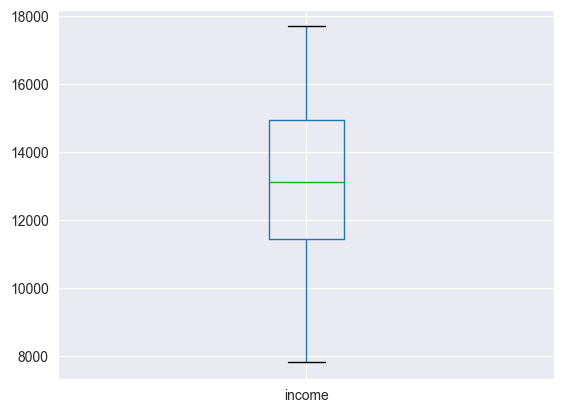

In [9]:
df_plus_emp[['income']].boxplot()

In [40]:
bd[['income']].dropna()

,income
6,13823.50
8,15323.50
9,15140.00
11,15059.60
15,10534.73
...,...
18671,16538.00
18675,12115.84
18677,11823.50
18680,15278.40


In [42]:
bd[['income']].dropna().shape[0] - bd[bd['income'] > 0][bd['income'] < np.percentile(bd['income'].dropna(), 75)][['income']].dropna().shape[0]

1197

In [43]:
bd['wo_hit_status_result_desc']

0          Дозвон, Отказ
1          Дозвон, Отказ
2          Дозвон, Отказ
3          Дозвон, Отказ
4          Дозвон, Отказ
              ...       
18686      Дозвон, Отказ
18687      Дозвон, Отказ
18688      Дозвон, Отказ
18689      Дозвон, Отказ
18690    Дозвон, Успешно
Name: wo_hit_status_result_desc, Length: 18691, dtype: object

In [44]:
result = {'Результат Звонка' : ['Дозвон, Отказ', 'Дозвон, Успешно'], 'Кол-во' : [16274, 2417]}
df_result = pd.DataFrame(result)
df_result

,Результат Звонка,Кол-во
0,"Дозвон, Отказ",16274
1,"Дозвон, Успешно",2417


In [18]:
df_plus_emp.pivot_table(index='functional_cd', values='flag', aggfunc='count')

,flag
functional_cd,
Activation,69
Afterfilling,1680
Agreement,393
Autoleads,22
BAF,47
Cold,994
Deposit,8
Downsell,159
Incoming,317


In [19]:
upsell4.pivot_table(index='region_size', values='flag', aggfunc='count')

NameError: name 'upsell4' is not defined

In [39]:
bd = pd.read_csv("final.csv")

In [35]:
bd['confirmed_income'].fillna(bd['predicted_income']).dropna().min()

np.float64(-6274.5)

In [37]:
np.percentile(bd['confirmed_income'].fillna(bd['predicted_income']).dropna(), 75)

np.float64(17698.135000000002)

In [40]:
bd.isna().sum().sum()

np.int64(168290)

In [42]:
df_plus_emp['gender_matching'].value_counts()

gender_matching
0    7570
1    5397
Name: count, dtype: int64

In [43]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

logreg = pd.get_dummies(df_plus_emp[['flag', 'gender_matching', 'matching_variance']], drop_first=True)

X = sm.add_constant(logreg.drop('flag', axis=1))
y = logreg['flag']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Коэффициенты модели
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print("\nModel Coefficients:\n", coefficients)

Accuracy: 0.8342328450269854

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      3246
           1       0.00      0.00      0.00       645

    accuracy                           0.83      3891
   macro avg       0.42      0.50      0.45      3891
weighted avg       0.70      0.83      0.76      3891


Model Coefficients:
                                      Feature  Coefficient
0                                      const    -0.858178
1                            gender_matching    -0.035612
2       matching_variance_Одинаковый возраст     0.149693
3  matching_variance_Оператор старше клиента     0.189261


In [45]:
logreg.isna().sum()

flag                                         0
gender_matching                              0
matching_variance_Одинаковый возраст         0
matching_variance_Оператор старше клиента    0
dtype: int64

In [59]:
import statsmodels.formula.api as smf
credits = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards', 'Cash Loan', 'Secured Loan', 'Car Loan', ''])]
logit_res = smf.glm('flag ~ C(gender_matching) + C(matching_variance)', credits, family = sm.families.Binomial()).fit()
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   flag   No. Observations:                12967
Model:                            GLM   Df Residuals:                    12963
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5743.8
Date:                Sat, 14 Dec 2024   Deviance:                       11488.
Time:                        05:30:02   Pearson chi2:                 1.30e+04
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0006197
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -1.6786      0.041    -41.138      0.000      -1.759      -1.599
C(gender_matching)[T.1]                            -0.0527      0.049     -1.085      0.278      -0.148       0.042
C(matching_variance)[T.Одинаковый возраст]          0.0632      0.061      1.029      0.303      -0.057       0.183
C(matching_variance)[T.Оператор старше клиента]     0.1424      0.055      2.585      0.010       0.034       0.250
===================================================================================================================
"""

In [56]:
df_plus_emp['product_cd'].value_counts()

product_cd
Credit Cards          6732
Cash Loan             2014
MVNO                  1416
Debit Cards           1320
Investment             491
Secured Loan           319
Casco                  245
Mortgage Insurance     205
Car Loan               193
Osago                   19
Deposit                  8
Travel Avia              3
T-Auto                   2
Name: count, dtype: int64